In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.patches import Ellipse
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score



In [2]:
original_df = pd.read_csv(r'../datasets/dataset_w_na/dataset.csv')
original_df = original_df.loc[:, ~original_df.columns.isin(['id'])]
original_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
columns = list(original_df.columns)
original_X = original_df.to_numpy()
print(original_X)

[['Male' 3.0 0 ... 18.0 nan 0]
 ['Male' 58.0 1 ... 39.2 'never smoked' 0]
 ['Female' 8.0 0 ... 17.6 nan 0]
 ...
 ['Female' 82.0 1 ... 28.9 'formerly smoked' 0]
 ['Male' 40.0 0 ... 33.2 'never smoked' 0]
 ['Female' 82.0 0 ... 20.6 'never smoked' 0]]


In [5]:
for col in columns:
    print(f"NaN in {col}: {original_df[col].isnull().sum()}")

NaN in gender: 0
NaN in age: 0
NaN in hypertension: 0
NaN in heart_disease: 0
NaN in ever_married: 0
NaN in work_type: 0
NaN in Residence_type: 0
NaN in avg_glucose_level: 0
NaN in bmi: 1462
NaN in smoking_status: 13292
NaN in stroke: 0


In [9]:
synthetic_df = pd.read_csv(r'../datasets/continuous_w_discreteTarget/synthetic.csv')
synthetic_df = synthetic_df[columns]
synthetic_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,9.582067,0.864727,0.216430,2.695922,0.081322,8.063538,15.173011,0.994710,3.252378,0.505812,11.722440,5
1,8.208484,0.465102,0.028454,3.658549,0.072635,9.360043,22.988563,0.994127,3.463537,0.744871,11.866676,5
2,9.099823,0.663394,0.236752,1.062344,0.093940,5.910659,20.380723,0.997278,3.376956,0.793022,11.513966,5
3,7.569382,0.537020,0.080665,3.241168,0.047722,2.577581,5.795272,0.996135,3.382150,0.421073,9.309241,5
4,5.886650,0.691991,-0.011778,1.188431,0.059731,4.130674,11.205299,0.995342,3.362238,0.700269,10.308484,5


In [10]:
synthetic_X = synthetic_df.to_numpy()
print(synthetic_X)

[[ 9.58206707  0.86472689  0.21642967 ...  0.50581181 11.72244042
   5.        ]
 [ 8.20848443  0.4651019   0.02845437 ...  0.74487141 11.86667635
   5.        ]
 [ 9.09982269  0.66339356  0.23675184 ...  0.79302233 11.51396578
   5.        ]
 ...
 [ 6.91921062  0.53714355  0.29258705 ...  0.62866539 10.17097447
   6.        ]
 [ 9.66979048  0.60886516  0.09069777 ...  1.13454527  8.93370976
   6.        ]
 [ 8.18353898  0.44872785  0.50105527 ...  0.95369031 10.48464732
   6.        ]]


In [11]:
print(original_X.shape)
print(synthetic_X.shape)

(1143, 12)
(1000, 12)


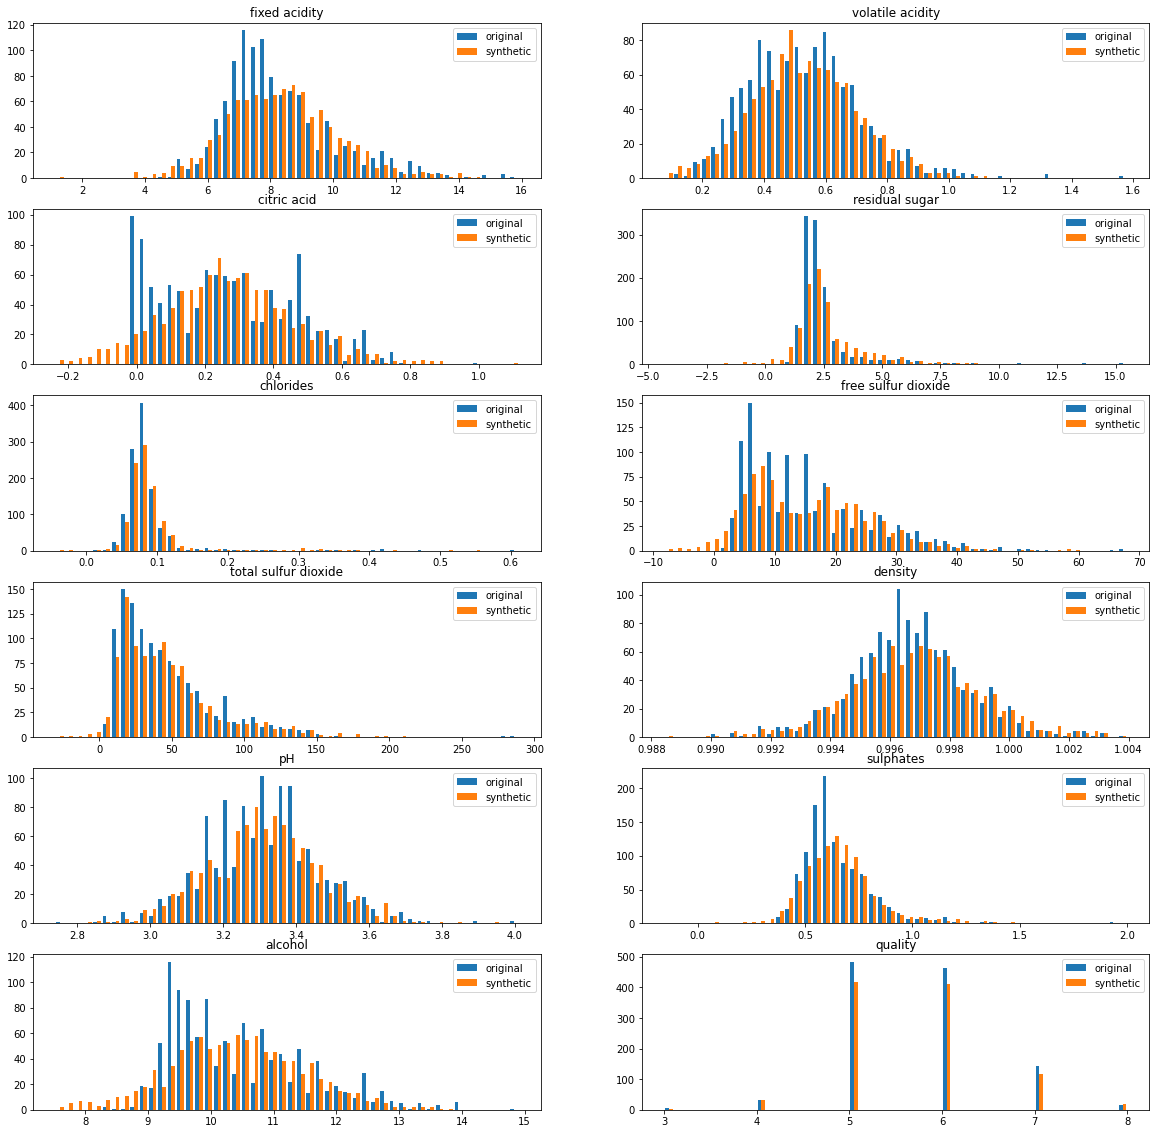

In [12]:
# plotting the distribution of the features using histogram

n_samples, n_features = original_X.shape
fig_rows = int(n_features/2) if n_features % 2 == 0 else int(n_features/2 + 1)
fig_columns = 2
bins = 50

fig,ax = plt.subplots(fig_rows, fig_columns, figsize=(20,20))
for i, feature in enumerate(range(n_features)):
    row_num = int(feature/fig_columns)
    col_num = feature%fig_columns
    if len(ax.shape) > 1:
        ax[row_num, col_num].hist([original_X[:, feature], synthetic_X[:, feature]],
                                  bins=bins,
                                  label=['original', 'synthetic'])
        ax[row_num, col_num].legend(['original', 'synthetic'])
        ax[row_num, col_num].title.set_text(f"{list(original_df.columns)[i]}")

    else:
        ax[col_num].hist([X[:, feature], Xn[0][:, feature]],
                         bins=bins, 
                         label=['original', 'synthetic'])
        ax[col_num].legend(['original', 'synthetic'])
        ax[col_num].title.set_text(f"{list(original_df.columns)[i]}")



In [14]:
from scipy.stats import chisquare
from scipy.stats import ks_2samp

print(list(original_df.columns))
categorical = ['quality']
continuous = ['fixed acidity', 'volatile acidity', 'citric acid',
              'residual sugar', 'chlorides', 'free sulfur dioxide',
              'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']



def get_probabilities(df, col):
    probs = []
    n = len(df[col])
    vals = sorted(list(df[col].unique()))
    cat_counts = df[col].value_counts()
    for cat in vals:
        probs.append(cat_counts[cat]/n)
    return vals, probs

# print((original_df['Region_Code'].unique()))
# print((synthetic_df['Region_Code'].unique()))

# print(unobserved)
# print(get_probabilities(original_df, 'Region_Code'))


for col in categorical:
    unobserved = [i for i in list(original_df[col].unique()) if i not in list(synthetic_df[col].unique())]
    o_vals, o_probs = get_probabilities(original_df, col)
    s_vals, s_probs = get_probabilities(synthetic_df, col)
    for j in unobserved:
        s_probs.insert(o_vals.index(j), 0)
    pvalue = chisquare(f_obs=s_probs, f_exp=o_probs).pvalue
    print(f"p-value for col {col}: {pvalue}")
for col in continuous:
    pvalue = ks_2samp(data1=original_df[col], data2=synthetic_df[col]).pvalue
    print(f"p-value for col {col}: {pvalue}")

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
p-value for col quality: 0.9999999862646688
p-value for col fixed acidity: 4.28499082885342e-05
p-value for col volatile acidity: 0.06045775340884432
p-value for col citric acid: 6.975630933365934e-05
p-value for col residual sugar: 6.430661686696357e-08
p-value for col chlorides: 0.0001359418335059623
p-value for col free sulfur dioxide: 0.0007372407273925216
p-value for col total sulfur dioxide: 0.22813674986471186
p-value for col density: 0.026438584384599784
p-value for col pH: 0.3596414314573252
p-value for col sulphates: 7.263040296912321e-05
p-value for col alcohol: 1.3319049987719604e-05


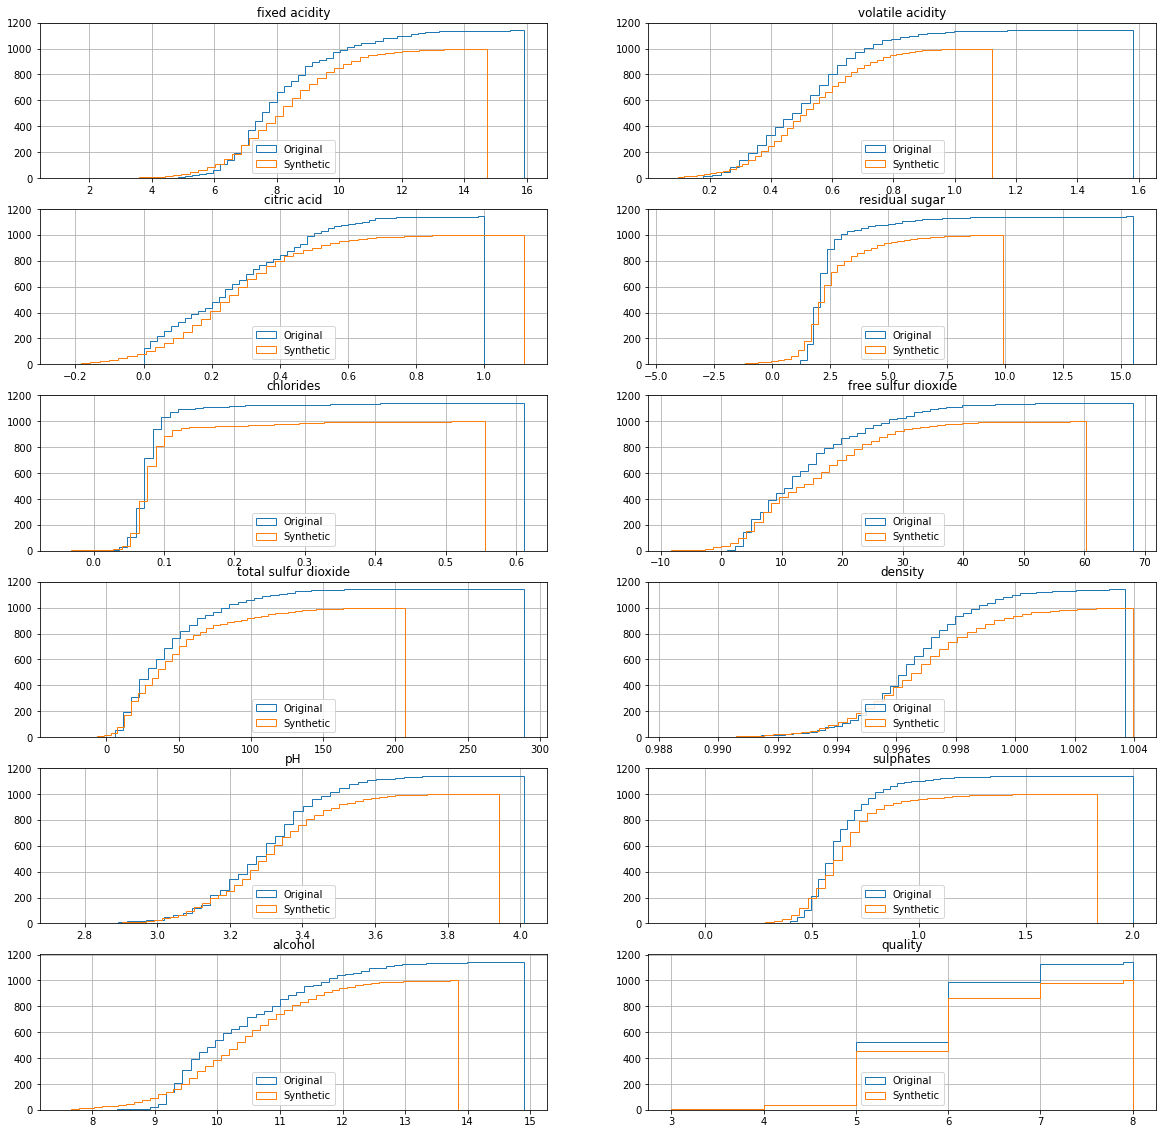

In [27]:
n_samples, n_features = original_X.shape
fig_rows = int(n_features/2) if n_features % 2 == 0 else int(n_features/2 + 1)
fig_columns = 2
bins = 50
fig,ax = plt.subplots(fig_rows, fig_columns, figsize=(20,20))


for i, feature in enumerate(range(n_features)):
    row_num = int(feature/fig_columns)
    col_num = feature%fig_columns
    if len(ax.shape) > 1:
        n0, bins0, patches0 = ax[row_num, col_num].hist(original_X[:, feature],
                              bins=bins,
                              histtype='step',
                              cumulative=True,
                              label='Original')
        n1, bins1, patches1 = ax[row_num, col_num].hist(synthetic_X[:, feature],
                              bins=bins,
                              histtype='step',
                              cumulative=True,
                              label='Synthetic')
        ax[row_num, col_num].grid(True)
        ax[row_num, col_num].legend(loc='lower center')
        ax[row_num, col_num].title.set_text(f"{list(original_df.columns)[i]}")

    else:
        ax[col_num].hist([X[:, feature], Xn[0][:, feature]],
                         bins=bins, 
                         label=['original', 'synthetic'])
        ax[col_num].legend(['original', 'synthetic'])
        ax[col_num].title.set_text(f"{list(original_df.columns)[i]}")
        n0, bins0, patches0 = ax[col_num].hist(original_X[:, feature],
                              bins=bins,
                              histtype='step',
                              cumulative=True,
                              label='Original')
        n1, bins1, patches1 = ax[col_num].hist(synthetic_X[:, feature],
                              bins=bins,
                              histtype='step',
                              cumulative=True,
                              label='Synthetic')
        ax[col_num].grid(True)
        ax[col_num].legend(loc='lower center')
        ax[col_num].title.set_text(f"{list(original_df.columns)[i]}")